##  Speed and Performance of GB libraries

Please make sure to install the following powerful packages for boosting:
* [xgboost](https://anaconda.org/conda-forge/xgboost)
* [lightgbm](https://anaconda.org/conda-forge/lightgbm)
* [catboost](https://tech.yandex.com/catboost/doc/dg/concepts/python-installation-docpage/)

In this task you are asked to compare the **training time** of the **GBDT**, the
Gradient Boosted Decision Trees, as implemeted by different popular ML libraries.
The dataset you shall use is the [UCI Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).
You should study the parameters of each library and establish the **correspondence**
between them.

The plan is as follows:
1. Take the **default** parameter settings, measure the training time, and plot
the ROC curves;
2. Use grid search with the $3$-fold cross valiadation to choose the best model.
Then measure the training time as a function of (separately) **tree depth** and **the
number of estimators in the ensemble**, finally **plot the ROC** curves of the best
models.

You need to make sure that you are comparing **comparable** classifiers, i.e. with
**the same tree and ensemble hyperparameters**.

<span style="color:green">**NOTE**</span> You need figure out how to make parameter settings
compatible. One possible way to understand the correspondence is to study the docs. You may
choose the default parameters from any library.

Please plot **three** ROC curves, one per library, on the same **one plot**
with a *comprehensible [legend](https://matplotlib.org/users/legend_guide.html)*.

A useful command for timing is IPython's [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=42)

In [2]:
from xgboost import XGBClassifier

In [3]:
from lightgbm import LGBMClassifier

In [4]:
!pip install catboost

In [5]:
from catboost import CatBoostClassifier

In [6]:
import time

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
import numpy as np

In [19]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [23]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_ = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=auc_)
#     step = len(thresholds) // 10
#     plt.scatter(fpr[::step], tpr[::step])
#     for f, t, th in zip(fpr[::step], tpr[::step], thresholds[::step]):
#         plt.annotate(np.round(th, 3), (f, t-0.08), color="b", fontsize=9)

    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()
    plt.title("ROC AUC")

In [26]:
%%time
clf = LGBMClassifier().fit(X_train, y_train)

Wall time: 86.8 ms


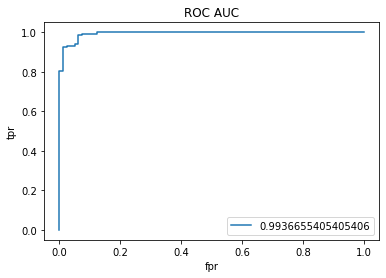

In [27]:
plot_roc(y_test, clf.predict_proba(X_test)[:, 1])

In [24]:
%%time
clf = XGBClassifier().fit(X_train, y_train)

Wall time: 86.8 ms


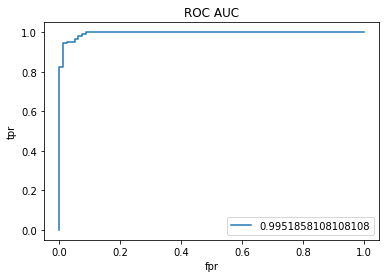

In [25]:
plot_roc(y_test, clf.predict_proba(X_test)[:, 1])

In [30]:
%%time
clf = CatBoostClassifier(verbose=0).fit(X_train, y_train)

Wall time: 4.53 s


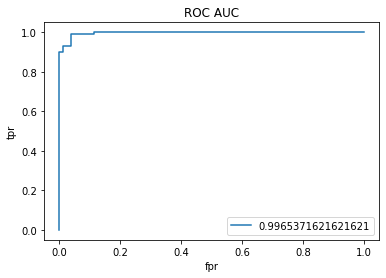

In [32]:
plot_roc(y_test, clf.predict_proba(X_test)[:, 1])

Зависимость ROC AUC и времени обучения от глубины деревьев в ансамбле:

In [33]:
def plot_roc_auc_max_depth(cls):
    r = []
    t = []

    rng = range(1, 13)

    for max_depth in rng:
        clf = cls(max_depth=max_depth, n_estimators=100, verbose=0)
        start = time.time()
        r.append(cross_val_score(clf, X, y, cv=3, scoring="roc_auc").mean())
        t.append(time.time() - start)

    fig, ax1 = plt.subplots()
    ax1.plot(rng, r, label="score", color="red")
    ax2 = ax1.twinx()
    ax2.plot(rng, t, label="time", color="blue")

    ax1.set_xlabel("max_depth")
    ax1.set_ylabel("roc auc", color="red")
    ax2.set_ylabel("time", color="blue")
    ax1.tick_params(axis='y', labelcolor="red")
    ax2.tick_params(axis='y', labelcolor="blue")

    plt.title(cls.__name__)

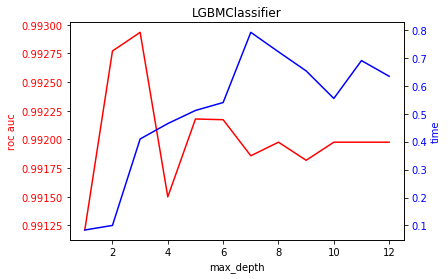

In [34]:
plot_roc_auc_max_depth(LGBMClassifier)

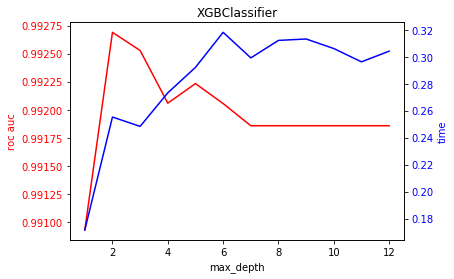

In [35]:
plot_roc_auc_max_depth(XGBClassifier)

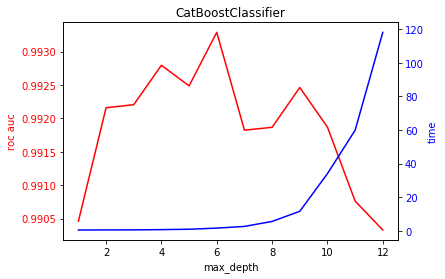

In [36]:
plot_roc_auc_max_depth(CatBoostClassifier)

Зависимость ROC AUC и времени обучения от количества деревьев в ансамбле:

In [37]:
def plot_roc_auc_n_estimators(cls):
    r = []
    t = []

    rng = range(10, 500, 10)

    for n_estimators in rng:
        clf = cls(max_depth=3, n_estimators=n_estimators, verbose=0)
        start = time.time()
        r.append(cross_val_score(clf, X, y, cv=3, scoring="roc_auc").mean())
        t.append(time.time() - start)

    fig, ax1 = plt.subplots()
    ax1.plot(rng, r, label="score", color="red")
    ax2 = ax1.twinx()
    ax2.plot(rng, t, label="time", color="blue")

    ax1.set_xlabel("n_estimators")
    ax1.set_ylabel("roc auc", color="red")
    ax2.set_ylabel("time", color="blue")
    ax1.tick_params(axis='y', labelcolor="red")
    ax2.tick_params(axis='y', labelcolor="blue")

    plt.title(cls.__name__)

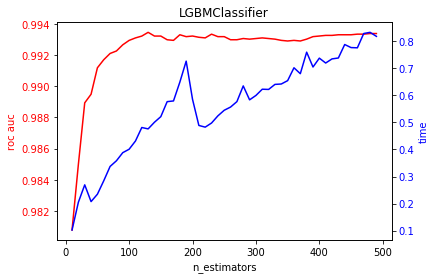

In [38]:
plot_roc_auc_n_estimators(LGBMClassifier)

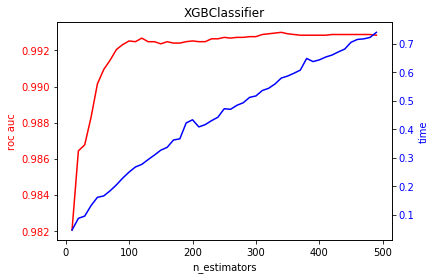

In [39]:
plot_roc_auc_n_estimators(XGBClassifier)

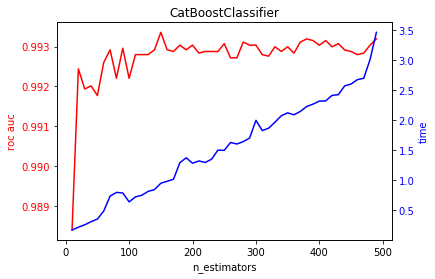

In [40]:
plot_roc_auc_n_estimators(CatBoostClassifier)

Поиск лучшего сочетания гиперпараметров:

In [41]:
def find_best_hyper(cls):

    r = []
    t = []

    rng = range(10, 300, 10)
    rng2 = range(1, 13)

    best_n_estimators = 0
    best_max_depth = 0
    best_score = 0

    for n_estimators in rng:
        for max_depth in rng2:
            clf = cls(max_depth=max_depth, n_estimators=n_estimators, verbose=0)
            score = cross_val_score(clf, X, y, cv=3, scoring="roc_auc").mean()
            if score > best_score:
                best_n_estimators = n_estimators
                best_max_depth = max_depth
                best_score = score

    clf = cls(max_depth=best_max_depth, n_estimators=best_n_estimators, verbose=0)
    pr = cross_val_predict(clf, X, y, cv=3, method="predict_proba")[:, 1]
    plot_roc(y, pr)
    print("n_estimators:", best_n_estimators)
    print("max_depth:", best_max_depth)

n_estimators: 290
max_depth: 2
Wall time: 2min 28s


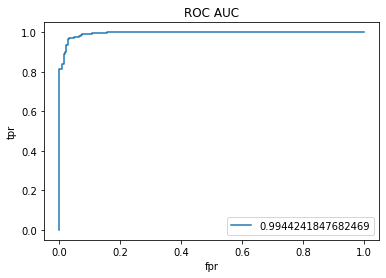

In [42]:
%%time
find_best_hyper(LGBMClassifier)

n_estimators: 180
max_depth: 2
Wall time: 1min 57s


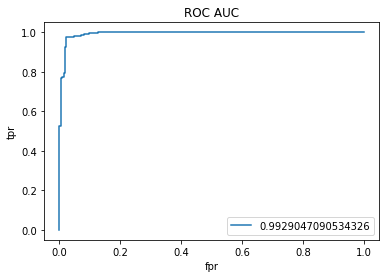

In [43]:
%%time
find_best_hyper(XGBClassifier)

n_estimators: 280
max_depth: 4
Wall time: 2h 54min 37s


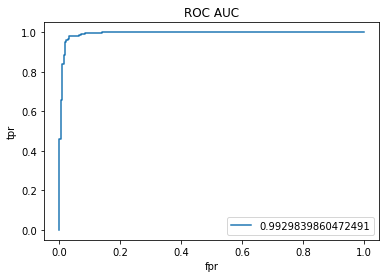

In [44]:
%%time
find_best_hyper(CatBoostClassifier)